# Demo of k-means clustering

[[-2.16656567 -2.19155884]
 [ 1.95578038  2.12407413]
 [ 0.15964763 -0.02783999]]


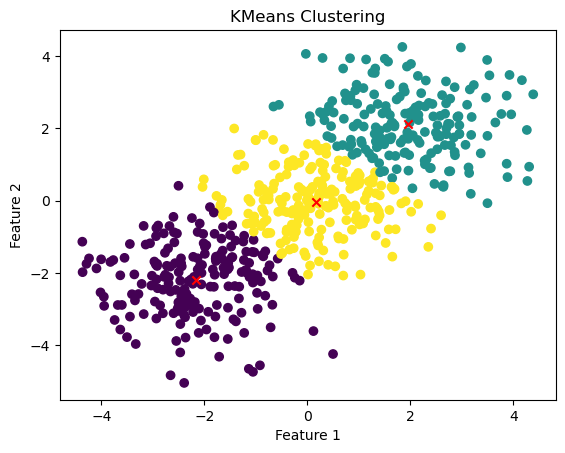

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kmeans import KMeans

# Generate a synthetic dataset
np.random.seed(0)
n_samples = 200
n_features = 2
n_clusters = 3

X = np.concatenate((
    np.random.randn(n_samples, n_features) + 2,
    np.random.randn(n_samples, n_features) - 2,
    np.random.randn(n_samples, n_features)
))

# Initialize and fit KMeans
kmeans = KMeans(n_clusters=n_clusters, max_iter=300)
kmeans.fit(X, cost_metric='squared_euclidean')

# Plot the data points and centroids
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', zorder=10)
plt.title("KMeans Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Geometric Median: [5 6]


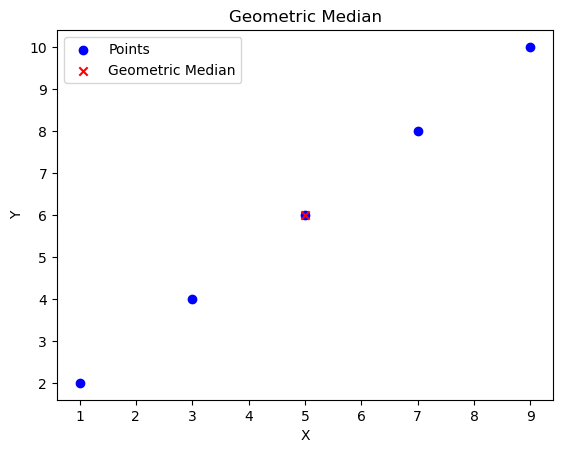

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def weiszfeld_algorithm(points, epsilon=1e-6, max_iterations=100):
    num_points, _ = points.shape

    # Initialize the geometric median as the mean of the points
    geometric_median = np.mean(points, axis=0)

    for iteration in range(max_iterations):
        # Calculate the distances from the current geometric median to all points
        distances = np.linalg.norm(points - geometric_median, axis=1)

        # Check for points that coincide with the geometric median
        coincident_points = np.isclose(distances, 0)
        if np.any(coincident_points):
            return points[coincident_points][0]

        # Add a small value to distances to avoid division by zero
        distances += np.finfo(float).eps

        # Update the geometric median
        weights = 1 / distances
        weights /= np.sum(weights)  # Normalize the weights
        geometric_median = np.dot(weights, points)

        # Check if the algorithm has converged
        if np.linalg.norm(geometric_median - np.dot(weights, points)) < epsilon:
            break

    return geometric_median

# Example usage
points = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
geometric_median = weiszfeld_algorithm(points)
print("Geometric Median:", geometric_median)

# Plotting
plt.scatter(points[:, 0], points[:, 1], color='blue', label='Points')
plt.scatter(geometric_median[0], geometric_median[1], color='red', marker='x', label='Geometric Median')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Geometric Median')
plt.legend()
plt.show()


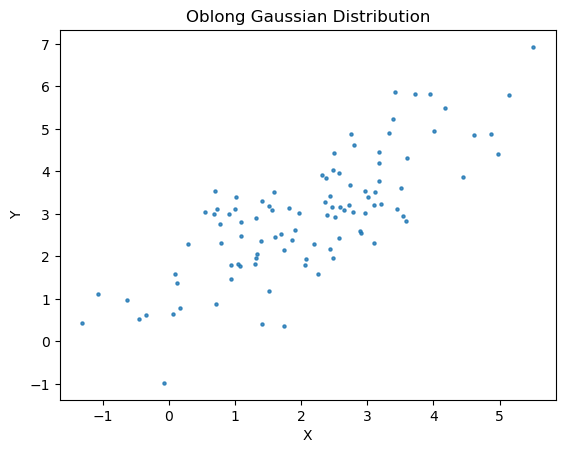

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Mean and covariance matrix of the oblong Gaussian distribution
mean = [2, 3]
cov = [[2, 1.5],
       [1.5, 2]]

# Number of points to generate
num_points = 100

# Generate points from the oblong Gaussian distribution
points = np.random.multivariate_normal(mean, cov, num_points)
print(points.shape)

# Plot the generated points
plt.scatter(points[:, 0], points[:, 1], s=5, alpha=0.8)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Oblong Gaussian Distribution')
plt.show()
